# EDA

### Imports 

In [2]:
import os
import cv2
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Set random seed for reproducibility
torch.manual_seed(42)

### Dataset class

In [10]:
class ToyboxDataset(Dataset):
    def __init__(self, root_dir, categories=['cat', 'duck', 'giraffe', 'horse'], 
                 transform=None, frames_per_clip=8):  # Reduced from 16 to 8 frames
        self.root_dir = Path(root_dir)
        self.categories = categories
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.samples = []
        
        # Create category to index mapping
        self.class_to_idx = {cat: idx for idx, cat in enumerate(categories)}
        
        # Build dataset
        self._build_dataset()
        
    def _build_dataset(self):
        for category in self.categories:
            category_path = self.root_dir / category
            object_folders = [d for d in category_path.iterdir() if d.is_dir()]
            
            for obj_folder in object_folders:
                video_files = list(obj_folder.glob('*.mp4'))
                for video_path in video_files:
                    self.samples.append({
                        'path': str(video_path),
                        'category': category,
                        'label': self.class_to_idx[category]
                    })
    
    def _load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            return self._create_dummy_frames()
        
        # Get total frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            return self._create_dummy_frames()
        
        # Calculate frame indices to sample, using earlier frames
        try:
            indices = np.linspace(0, min(total_frames//2, 300), self.frames_per_clip, dtype=int)
        except:
            cap.release()
            return self._create_dummy_frames()
        
        for frame_idx in indices:
            try:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
                else:
                    frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
            except:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
                
        cap.release()
        
        # If we didn't get enough frames, pad with zeros
        while len(frames) < self.frames_per_clip:
            frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
        
        return np.stack(frames[:self.frames_per_clip])
    
    def _create_dummy_frames(self):
        return np.zeros((self.frames_per_clip, 224, 224, 3), dtype=np.uint8)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load video frames
        frames = self._load_video(sample['path'])
        
        # Apply transforms
        if self.transform:
            try:
                transformed_frames = []
                for frame in frames:
                    frame_tensor = self.transform(frame)
                    transformed_frames.append(frame_tensor)
                transformed_frames = torch.stack(transformed_frames)
            except:
                # Return zero tensor if transform fails
                transformed_frames = torch.zeros((self.frames_per_clip, 3, 224, 224))
        else:
            transformed_frames = torch.FloatTensor(frames.transpose(0, 3, 1, 2))
        
        return transformed_frames, sample['label']

### Create dataset and data loaders

In [11]:
# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset with fewer frames per clip
dataset = ToyboxDataset(
    root_dir='/Users/emmamaielinrattray/toybox/data',
    transform=transform,
    frames_per_clip=8  # Reduced from 16 to 8
)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders with smaller batch size
train_loader = DataLoader(
    train_dataset, 
    batch_size=2,  # Reduced batch size
    shuffle=True, 
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=2,  # Reduced batch size
    shuffle=False, 
    num_workers=0
)

### Model definition 

In [7]:
class ToyboxModel(torch.nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = resnet18(weights=True)
        self.backbone.fc = torch.nn.Linear(512, num_classes)
        
    def forward(self, x):
        b, f, c, h, w = x.shape
        x = x.view(b * f, c, h, w)
        x = self.backbone(x)
        x = x.view(b, f, -1)
        x = torch.mean(x, dim=1)
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = ToyboxModel().to(device)

Using device: cpu


/Users/emmamaielinrattray/opt/anaconda3/envs/toybox/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training functions

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (frames, labels) in enumerate(tqdm(loader)):
        try:
            frames, labels = frames.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if i % 20 == 0:
                print(f'\nBatch {i}: Loss: {loss.item():.4f}, '
                      f'Acc: {100. * correct / total:.2f}%')
                
            del frames, labels, outputs
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            continue
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for frames, labels in tqdm(loader):
            try:
                frames, labels = frames.to(device), labels.to(device)
                outputs = model(frames)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                del frames, labels, outputs
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                
            except Exception as e:
                print(f"Error during validation: {e}")
                continue
    
    return running_loss / len(loader), 100. * correct / total

### Training Loop
N.B this took 3 hrs 8 mins to run on Emma's computer

In [13]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

print("Starting training...")
train_losses = []
train_accs = []
val_losses = []
val_accs = []

try:
    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, f'toybox_model_checkpoint_epoch_{epoch+1}.pth')

except Exception as e:
    print(f"Training interrupted: {e}")
    torch.save(model.state_dict(), 'toybox_model_interrupted.pth')

Starting training...

Epoch: 1/5


  0%|          | 1/576 [00:02<27:15,  2.84s/it]


Batch 0: Loss: 1.2884, Acc: 0.00%


  4%|▎         | 21/576 [00:57<25:01,  2.71s/it]


Batch 20: Loss: 1.3663, Acc: 40.48%


  7%|▋         | 41/576 [01:58<26:03,  2.92s/it]


Batch 40: Loss: 1.0733, Acc: 40.24%


 11%|█         | 61/576 [02:59<25:13,  2.94s/it]


Batch 60: Loss: 0.6288, Acc: 43.44%


 14%|█▍        | 81/576 [03:54<23:07,  2.80s/it]


Batch 80: Loss: 0.7414, Acc: 42.59%


 18%|█▊        | 101/576 [04:49<22:21,  2.82s/it]


Batch 100: Loss: 0.5289, Acc: 43.07%


 21%|██        | 121/576 [05:46<21:15,  2.80s/it]


Batch 120: Loss: 0.7234, Acc: 45.87%


 24%|██▍       | 141/576 [06:43<20:14,  2.79s/it]


Batch 140: Loss: 0.4060, Acc: 47.52%


 28%|██▊       | 161/576 [07:38<18:27,  2.67s/it]


Batch 160: Loss: 0.8372, Acc: 48.45%


 31%|███▏      | 181/576 [08:35<19:10,  2.91s/it]


Batch 180: Loss: 1.5243, Acc: 50.00%


 35%|███▍      | 201/576 [09:32<18:06,  2.90s/it]


Batch 200: Loss: 0.6203, Acc: 51.24%


 38%|███▊      | 221/576 [10:31<16:47,  2.84s/it]


Batch 220: Loss: 0.3343, Acc: 54.52%


 42%|████▏     | 241/576 [11:29<17:47,  3.19s/it]


Batch 240: Loss: 0.8986, Acc: 55.19%


 45%|████▌     | 261/576 [12:25<14:41,  2.80s/it]


Batch 260: Loss: 0.2528, Acc: 55.56%


 49%|████▉     | 281/576 [13:24<15:21,  3.12s/it]


Batch 280: Loss: 0.2634, Acc: 56.58%


 52%|█████▏    | 301/576 [14:20<12:57,  2.83s/it]


Batch 300: Loss: 0.2499, Acc: 56.64%


 56%|█████▌    | 321/576 [15:19<13:11,  3.10s/it]


Batch 320: Loss: 0.5636, Acc: 57.01%


 59%|█████▉    | 341/576 [16:21<12:07,  3.09s/it]


Batch 340: Loss: 1.1219, Acc: 56.16%


 63%|██████▎   | 361/576 [17:31<14:02,  3.92s/it]


Batch 360: Loss: 1.9808, Acc: 55.68%


 66%|██████▌   | 381/576 [18:30<09:19,  2.87s/it]


Batch 380: Loss: 1.1729, Acc: 55.64%


 70%|██████▉   | 401/576 [19:28<08:00,  2.75s/it]


Batch 400: Loss: 0.9143, Acc: 55.36%


 73%|███████▎  | 421/576 [20:25<07:36,  2.95s/it]


Batch 420: Loss: 1.5273, Acc: 56.06%


 77%|███████▋  | 441/576 [21:26<07:06,  3.16s/it]


Batch 440: Loss: 1.2711, Acc: 55.90%


 80%|████████  | 461/576 [22:27<05:44,  2.99s/it]


Batch 460: Loss: 0.6459, Acc: 56.62%


 84%|████████▎ | 481/576 [23:25<04:37,  2.92s/it]


Batch 480: Loss: 0.1463, Acc: 57.38%


 87%|████████▋ | 501/576 [24:24<03:33,  2.85s/it]


Batch 500: Loss: 0.1165, Acc: 57.68%


 90%|█████████ | 521/576 [25:23<02:38,  2.88s/it]


Batch 520: Loss: 1.6748, Acc: 57.97%


 94%|█████████▍| 541/576 [26:24<01:47,  3.06s/it]


Batch 540: Loss: 0.2106, Acc: 58.60%


 97%|█████████▋| 561/576 [27:25<00:43,  2.92s/it]


Batch 560: Loss: 0.2398, Acc: 59.00%


100%|██████████| 144/144 [05:52<00:00,  2.45s/it]


Train Loss: 1.0017, Train Acc: 59.46%
Val Loss: 0.6362, Val Acc: 75.35%

Epoch: 2/5


  0%|          | 1/576 [00:03<29:43,  3.10s/it]


Batch 0: Loss: 0.2048, Acc: 100.00%


  4%|▎         | 21/576 [01:03<28:25,  3.07s/it]


Batch 20: Loss: 0.1377, Acc: 78.57%


  7%|▋         | 41/576 [02:02<26:14,  2.94s/it]


Batch 40: Loss: 0.1783, Acc: 75.61%


 11%|█         | 61/576 [03:00<25:23,  2.96s/it]


Batch 60: Loss: 0.2898, Acc: 76.23%


 14%|█▍        | 81/576 [03:58<24:03,  2.92s/it]


Batch 80: Loss: 1.4968, Acc: 77.78%


 18%|█▊        | 101/576 [04:57<23:16,  2.94s/it]


Batch 100: Loss: 0.2373, Acc: 75.25%


 21%|██        | 121/576 [05:54<21:35,  2.85s/it]


Batch 120: Loss: 1.2917, Acc: 75.62%


 24%|██▍       | 141/576 [06:52<20:55,  2.89s/it]


Batch 140: Loss: 0.7582, Acc: 74.47%


 28%|██▊       | 161/576 [07:50<20:29,  2.96s/it]


Batch 160: Loss: 0.1810, Acc: 74.22%


 31%|███▏      | 181/576 [08:50<19:34,  2.97s/it]


Batch 180: Loss: 0.0971, Acc: 74.31%


 35%|███▍      | 201/576 [09:59<22:06,  3.54s/it]


Batch 200: Loss: 1.3620, Acc: 73.88%


 38%|███▊      | 221/576 [11:14<21:42,  3.67s/it]


Batch 220: Loss: 1.0045, Acc: 74.43%


 42%|████▏     | 241/576 [12:27<19:56,  3.57s/it]


Batch 240: Loss: 0.2437, Acc: 74.48%


 45%|████▌     | 261/576 [13:37<18:40,  3.56s/it]


Batch 260: Loss: 0.1234, Acc: 75.10%


 49%|████▉     | 281/576 [14:47<17:01,  3.46s/it]


Batch 280: Loss: 0.9551, Acc: 75.09%


 52%|█████▏    | 301/576 [15:57<16:01,  3.50s/it]


Batch 300: Loss: 0.7609, Acc: 75.08%


 56%|█████▌    | 321/576 [17:06<15:03,  3.54s/it]


Batch 320: Loss: 0.3262, Acc: 75.55%


 59%|█████▉    | 341/576 [18:17<13:50,  3.54s/it]


Batch 340: Loss: 0.1205, Acc: 75.66%


 63%|██████▎   | 361/576 [19:27<12:21,  3.45s/it]


Batch 360: Loss: 2.3394, Acc: 76.18%


 66%|██████▌   | 381/576 [20:36<11:06,  3.42s/it]


Batch 380: Loss: 0.1326, Acc: 75.72%


 70%|██████▉   | 401/576 [21:47<10:13,  3.51s/it]


Batch 400: Loss: 0.3001, Acc: 75.94%


 73%|███████▎  | 421/576 [22:57<09:08,  3.54s/it]


Batch 420: Loss: 1.2479, Acc: 75.77%


 77%|███████▋  | 441/576 [24:06<08:43,  3.88s/it]


Batch 440: Loss: 0.9487, Acc: 76.08%


 80%|████████  | 461/576 [25:06<05:29,  2.87s/it]


Batch 460: Loss: 0.7919, Acc: 76.36%


 84%|████████▎ | 481/576 [26:05<04:48,  3.04s/it]


Batch 480: Loss: 0.0860, Acc: 76.82%


 87%|████████▋ | 501/576 [27:03<03:36,  2.89s/it]


Batch 500: Loss: 1.3092, Acc: 76.85%


 90%|█████████ | 521/576 [28:02<02:38,  2.88s/it]


Batch 520: Loss: 1.1931, Acc: 76.97%


 94%|█████████▍| 541/576 [29:00<01:40,  2.87s/it]


Batch 540: Loss: 0.1909, Acc: 76.99%


 97%|█████████▋| 561/576 [30:00<00:44,  2.97s/it]


Batch 560: Loss: 0.1893, Acc: 77.54%


100%|██████████| 144/144 [05:40<00:00,  2.37s/it]


Train Loss: 0.6325, Train Acc: 77.78%
Val Loss: 0.2479, Val Acc: 89.58%

Epoch: 3/5


  0%|          | 1/576 [00:02<28:43,  3.00s/it]


Batch 0: Loss: 1.1264, Acc: 0.00%


  4%|▎         | 21/576 [01:00<26:44,  2.89s/it]


Batch 20: Loss: 0.1368, Acc: 73.81%


  7%|▋         | 41/576 [02:00<26:46,  3.00s/it]


Batch 40: Loss: 0.1127, Acc: 85.37%


 11%|█         | 61/576 [02:59<25:48,  3.01s/it]


Batch 60: Loss: 0.9277, Acc: 86.07%


 14%|█▍        | 81/576 [03:59<23:56,  2.90s/it]


Batch 80: Loss: 0.6348, Acc: 85.80%


 18%|█▊        | 101/576 [04:59<24:00,  3.03s/it]


Batch 100: Loss: 0.1361, Acc: 86.63%


 21%|██        | 121/576 [05:59<22:45,  3.00s/it]


Batch 120: Loss: 0.2933, Acc: 85.54%


 24%|██▍       | 141/576 [06:59<21:51,  3.01s/it]


Batch 140: Loss: 0.0690, Acc: 86.17%


 28%|██▊       | 161/576 [07:58<20:40,  2.99s/it]


Batch 160: Loss: 0.9175, Acc: 86.65%


 31%|███▏      | 181/576 [08:59<19:17,  2.93s/it]


Batch 180: Loss: 1.1765, Acc: 86.74%


 35%|███▍      | 201/576 [09:58<18:39,  2.98s/it]


Batch 200: Loss: 1.1252, Acc: 87.06%


 38%|███▊      | 221/576 [10:59<17:50,  3.01s/it]


Batch 220: Loss: 0.1660, Acc: 87.33%


 42%|████▏     | 241/576 [11:58<16:21,  2.93s/it]


Batch 240: Loss: 0.7958, Acc: 87.34%


 45%|████▌     | 261/576 [12:59<16:08,  3.07s/it]


Batch 260: Loss: 1.3147, Acc: 87.16%


 49%|████▉     | 281/576 [14:02<16:20,  3.33s/it]


Batch 280: Loss: 0.9633, Acc: 87.37%


 52%|█████▏    | 301/576 [15:11<15:47,  3.45s/it]


Batch 300: Loss: 0.0376, Acc: 87.71%


 56%|█████▌    | 321/576 [16:21<14:54,  3.51s/it]


Batch 320: Loss: 0.1690, Acc: 88.01%


 59%|█████▉    | 341/576 [17:31<13:49,  3.53s/it]


Batch 340: Loss: 0.0416, Acc: 87.83%


 63%|██████▎   | 361/576 [18:42<12:48,  3.58s/it]


Batch 360: Loss: 0.1827, Acc: 87.40%


 66%|██████▌   | 381/576 [19:52<11:34,  3.56s/it]


Batch 380: Loss: 0.0996, Acc: 87.14%


 70%|██████▉   | 401/576 [21:02<09:57,  3.42s/it]


Batch 400: Loss: 2.0309, Acc: 87.28%


 73%|███████▎  | 421/576 [22:13<09:11,  3.56s/it]


Batch 420: Loss: 0.1994, Acc: 86.46%


 77%|███████▋  | 441/576 [23:26<08:24,  3.74s/it]


Batch 440: Loss: 0.7806, Acc: 85.94%


 80%|████████  | 461/576 [24:41<07:17,  3.80s/it]


Batch 460: Loss: 0.2383, Acc: 85.68%


 84%|████████▎ | 481/576 [25:56<05:58,  3.77s/it]


Batch 480: Loss: 1.3122, Acc: 85.55%


 87%|████████▋ | 501/576 [27:10<04:38,  3.71s/it]


Batch 500: Loss: 0.1606, Acc: 85.63%


 90%|█████████ | 521/576 [28:26<03:31,  3.84s/it]


Batch 520: Loss: 0.2291, Acc: 85.80%


 94%|█████████▍| 541/576 [29:42<02:12,  3.78s/it]


Batch 540: Loss: 0.0351, Acc: 85.95%


 97%|█████████▋| 561/576 [30:57<00:56,  3.75s/it]


Batch 560: Loss: 0.9409, Acc: 86.19%


100%|██████████| 144/144 [06:47<00:00,  2.83s/it]


Train Loss: 0.4264, Train Acc: 86.37%
Val Loss: 0.2181, Val Acc: 91.32%

Epoch: 4/5


  0%|          | 1/576 [00:03<36:42,  3.83s/it]


Batch 0: Loss: 0.0529, Acc: 100.00%


  4%|▎         | 21/576 [01:15<32:49,  3.55s/it]


Batch 20: Loss: 0.3183, Acc: 95.24%


  7%|▋         | 41/576 [02:26<31:01,  3.48s/it]


Batch 40: Loss: 0.5835, Acc: 95.12%


 11%|█         | 61/576 [03:36<29:49,  3.47s/it]


Batch 60: Loss: 0.1186, Acc: 92.62%


 14%|█▍        | 81/576 [04:45<28:28,  3.45s/it]


Batch 80: Loss: 0.0243, Acc: 91.36%


 18%|█▊        | 101/576 [05:56<27:00,  3.41s/it]


Batch 100: Loss: 0.0291, Acc: 91.58%


 21%|██        | 121/576 [07:06<26:11,  3.45s/it]


Batch 120: Loss: 0.0536, Acc: 92.15%


 24%|██▍       | 141/576 [08:17<26:09,  3.61s/it]


Batch 140: Loss: 0.0747, Acc: 92.55%


 28%|██▊       | 161/576 [09:32<26:22,  3.81s/it]


Batch 160: Loss: 0.3011, Acc: 92.24%


 31%|███▏      | 181/576 [10:47<24:29,  3.72s/it]


Batch 180: Loss: 0.0527, Acc: 92.27%


 35%|███▍      | 201/576 [12:01<23:01,  3.68s/it]


Batch 200: Loss: 1.1190, Acc: 92.29%


 38%|███▊      | 221/576 [13:16<22:10,  3.75s/it]


Batch 220: Loss: 0.8695, Acc: 92.08%


 42%|████▏     | 241/576 [14:32<20:42,  3.71s/it]


Batch 240: Loss: 0.0692, Acc: 92.74%


 45%|████▌     | 261/576 [15:46<19:43,  3.76s/it]


Batch 260: Loss: 0.0308, Acc: 93.10%


 49%|████▉     | 281/576 [17:01<18:23,  3.74s/it]


Batch 280: Loss: 0.0324, Acc: 93.24%


 52%|█████▏    | 301/576 [18:16<17:35,  3.84s/it]


Batch 300: Loss: 0.1012, Acc: 92.86%


 56%|█████▌    | 321/576 [19:30<15:24,  3.63s/it]


Batch 320: Loss: 0.1934, Acc: 92.37%


 59%|█████▉    | 341/576 [20:44<14:18,  3.65s/it]


Batch 340: Loss: 0.5875, Acc: 92.08%


 63%|██████▎   | 361/576 [21:53<12:34,  3.51s/it]


Batch 360: Loss: 0.0809, Acc: 91.97%


 66%|██████▌   | 381/576 [23:04<11:22,  3.50s/it]


Batch 380: Loss: 0.6270, Acc: 91.86%


 70%|██████▉   | 401/576 [24:15<10:15,  3.52s/it]


Batch 400: Loss: 0.5331, Acc: 91.65%


 73%|███████▎  | 421/576 [25:25<09:13,  3.57s/it]


Batch 420: Loss: 0.1365, Acc: 91.69%


 77%|███████▋  | 441/576 [26:36<07:52,  3.50s/it]


Batch 440: Loss: 0.3888, Acc: 91.61%


 80%|████████  | 461/576 [27:45<06:41,  3.49s/it]


Batch 460: Loss: 0.0281, Acc: 91.54%


 84%|████████▎ | 481/576 [28:55<05:25,  3.42s/it]


Batch 480: Loss: 0.4219, Acc: 90.96%


 87%|████████▋ | 501/576 [30:05<04:27,  3.57s/it]


Batch 500: Loss: 0.0806, Acc: 90.92%


 90%|█████████ | 521/576 [31:17<03:14,  3.54s/it]


Batch 520: Loss: 0.9996, Acc: 90.98%


 94%|█████████▍| 541/576 [32:26<02:00,  3.44s/it]


Batch 540: Loss: 1.1173, Acc: 90.94%


 97%|█████████▋| 561/576 [33:39<00:55,  3.70s/it]


Batch 560: Loss: 0.7530, Acc: 90.91%


100%|██████████| 144/144 [06:49<00:00,  2.84s/it]


Train Loss: 0.2924, Train Acc: 90.80%
Val Loss: 0.2084, Val Acc: 91.32%

Epoch: 5/5


  0%|          | 1/576 [00:02<28:33,  2.98s/it]


Batch 0: Loss: 0.0233, Acc: 100.00%


  4%|▎         | 21/576 [01:07<30:53,  3.34s/it]


Batch 20: Loss: 0.0456, Acc: 90.48%


  7%|▋         | 41/576 [02:08<26:56,  3.02s/it]


Batch 40: Loss: 0.0140, Acc: 90.24%


 11%|█         | 61/576 [03:10<27:18,  3.18s/it]


Batch 60: Loss: 0.6814, Acc: 90.16%


 14%|█▍        | 81/576 [04:11<24:56,  3.02s/it]


Batch 80: Loss: 0.0223, Acc: 90.74%


 18%|█▊        | 101/576 [05:12<24:07,  3.05s/it]


Batch 100: Loss: 0.1094, Acc: 90.59%


 21%|██        | 121/576 [06:17<24:49,  3.27s/it]


Batch 120: Loss: 0.0248, Acc: 91.32%


 24%|██▍       | 141/576 [07:21<23:12,  3.20s/it]


Batch 140: Loss: 0.0769, Acc: 91.84%


 28%|██▊       | 161/576 [08:24<22:38,  3.27s/it]


Batch 160: Loss: 0.0382, Acc: 92.55%


 31%|███▏      | 181/576 [09:26<21:00,  3.19s/it]


Batch 180: Loss: 0.0197, Acc: 92.82%


 35%|███▍      | 201/576 [10:26<19:46,  3.16s/it]


Batch 200: Loss: 0.5888, Acc: 92.79%


 38%|███▊      | 221/576 [11:29<19:05,  3.23s/it]


Batch 220: Loss: 0.1310, Acc: 92.76%


 42%|████▏     | 241/576 [12:31<16:44,  3.00s/it]


Batch 240: Loss: 0.0347, Acc: 92.95%


 45%|████▌     | 261/576 [13:31<14:37,  2.78s/it]


Batch 260: Loss: 0.0253, Acc: 93.10%


 49%|████▉     | 281/576 [14:30<17:22,  3.53s/it]


Batch 280: Loss: 0.0660, Acc: 92.70%


 52%|█████▏    | 301/576 [15:34<14:08,  3.08s/it]


Batch 300: Loss: 0.0215, Acc: 92.86%


 56%|█████▌    | 321/576 [16:32<13:20,  3.14s/it]


Batch 320: Loss: 0.3083, Acc: 92.68%


 59%|█████▉    | 341/576 [17:27<11:00,  2.81s/it]


Batch 340: Loss: 0.5137, Acc: 92.38%


 63%|██████▎   | 361/576 [18:25<10:10,  2.84s/it]


Batch 360: Loss: 0.0170, Acc: 92.38%


 66%|██████▌   | 381/576 [19:20<09:05,  2.80s/it]


Batch 380: Loss: 0.0184, Acc: 92.52%


 70%|██████▉   | 401/576 [20:15<08:04,  2.77s/it]


Batch 400: Loss: 0.0330, Acc: 92.64%


 73%|███████▎  | 421/576 [21:10<06:59,  2.71s/it]


Batch 420: Loss: 0.2790, Acc: 92.52%


 77%|███████▋  | 441/576 [22:06<06:18,  2.80s/it]


Batch 440: Loss: 1.2690, Acc: 92.52%


 80%|████████  | 461/576 [23:06<05:36,  2.93s/it]


Batch 460: Loss: 0.4015, Acc: 92.41%


 84%|████████▎ | 481/576 [24:02<04:29,  2.84s/it]


Batch 480: Loss: 0.0659, Acc: 92.31%


 87%|████████▋ | 501/576 [25:02<04:03,  3.24s/it]


Batch 500: Loss: 0.0703, Acc: 92.22%


 90%|█████████ | 521/576 [26:12<03:53,  4.24s/it]


Batch 520: Loss: 0.2211, Acc: 92.23%


 94%|█████████▍| 541/576 [27:10<01:39,  2.84s/it]


Batch 540: Loss: 0.0387, Acc: 92.33%


 97%|█████████▋| 561/576 [28:05<00:40,  2.67s/it]


Batch 560: Loss: 0.4804, Acc: 92.16%


100%|██████████| 144/144 [05:34<00:00,  2.32s/it]


Train Loss: 0.2297, Train Acc: 92.10%
Val Loss: 0.4447, Val Acc: 81.94%


### Results

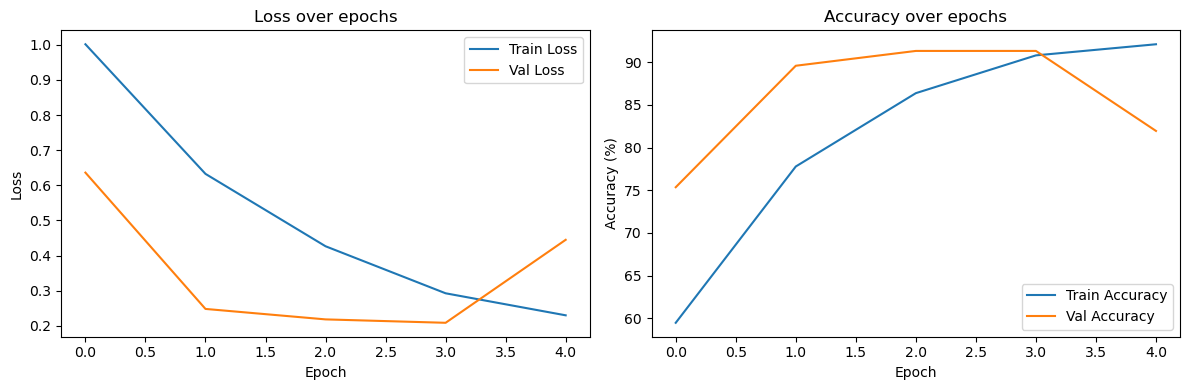

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()